# 1-D CNN model for CAP classification 
- Authors - Shruti Murarka, Aditya Wadichar

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [3]:
from os import listdir
csvs=['Balanced data/'+i for i in listdir('Balanced Data')]
csvs

['Balanced data/bal_all.csv',
 'Balanced data/bal_healthy.csv',
 'Balanced data/bal_healthy_F4C4.csv',
 'Balanced data/bal_ins.csv',
 'Balanced data/bal_narco.csv',
 'Balanced data/bal_nfle.csv',
 'Balanced data/bal_plm.csv',
 'Balanced data/bal_rbd.csv',
 'Balanced data/bal_sdb.csv']

In [27]:
n_epochs=200
batch_size=75

## Dataset

In [5]:
# preparing dataset
# bal_all = np.loadtxt('/content/drive/MyDrive/FYP/A1_A2_A3_B_data/Data_csv/bal_healthy.csv', delimiter=',')
# bal_all = np.loadtxt('DATA_A1_A2_A3_B/Data_combine/bal_healthy.csv', delimiter=',')
bal_all = np.loadtxt(csvs[0], delimiter=',')
x_bal = bal_all[:,0:1024]
y_bal = bal_all[:,1024]
y_bal=y_bal.reshape(-1,1 )

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_bal)
onehotlabels = enc.transform(y_bal).toarray()
onelabel=np.absolute(1-onehotlabels[:,0])
onelabel=(onelabel.reshape(-1,1)).astype(int)
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_bal, onelabel, test_size = 0.2, shuffle = True)

In [6]:
print(np.unique(y_bal))
print(np.unique(onelabel))

[0. 1. 2. 3.]
[0 1]


In [7]:
from keras.utils import to_categorical
num_classes=2
y_train1_encoded = to_categorical(y_train1, num_classes=num_classes)
y_test1_encoded = to_categorical(y_test1, num_classes=num_classes)

2024-06-05 10:41:24.274003: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-05 10:41:24.314609: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 10:41:24.837569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-06-05 10:41:25.497190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 10:41:25.538548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 10:41:25.538609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [9]:
import matplotlib.pyplot as plt
def plotaccloss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 6))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r*-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Paper

### Hyperparameter Optimization

In [52]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *
from keras.layers import Dense
from keras.layers import LSTM
# from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Conv1D

param = 16
kfold = KFold(n_splits=5, shuffle=True, random_state=1) 
fold_no = 1
acc_per_fold1 = []
loss_per_fold1 = []
for train, test in kfold.split(x_train1,  y_train1):
    model = Sequential()
    model.add(tfl.Conv1D(filters=32,
                    kernel_size=7,
                    strides=1,
                    padding='same',
            input_shape=(1024,1)))
   
    model.add(tfl.Conv1D(filters=8,
                    kernel_size=3,
                    strides=1,
                    padding='same', activation='relu'))
    model.add(tfl.MaxPool1D(pool_size= 16,
                       padding='same'))
    model.add(tfl.Conv1D(filters=16,
                    kernel_size=2,
                    strides=1,
                    padding='same'))
    model.add(tfl.Dropout(0.4))
    model.add(tfl.Conv1D(filters=8,
                    kernel_size=2,
                    strides=1,
                    padding='same',activation='relu'))
    model.add(tfl.MaxPool1D(pool_size= 4,
                       padding='same'))
    model.add(tfl.Flatten())
    model.add(tfl.Dense(param, activation='relu'))    ## parameter change
    model.add(tfl.Dense(1, activation='sigmoid'))
    model.compile(optimizer = 'adam',
                  loss='binary_crossentropy',
              metrics=['accuracy'])
    

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    
    # Fit data to model
    history1 = model.fit(x_train1[train], y_train1[train],
                batch_size=75,
                epochs=50)

    # Generate generalization metrics
    scores1 = model.evaluate(x_train1[test], y_train1[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores1[0]}; {model.metrics_names[1]} of {scores1[1]*100}%')
    acc_per_fold1.append(scores1[1] * 100)
    loss_per_fold1.append(scores1[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4800 - loss: 1.8539
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5190 - loss: 0.6988
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5517 - loss: 0.6898
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5910 - loss: 0.6777
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5836 - loss: 0.6717
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5764 - loss: 0.6776
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6113 - loss: 0.6582
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6088 - loss: 0.6569
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6169 - loss: 0.6491
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6199 - loss: 0.6528
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

In [53]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold1)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold1[i]} - Accuracy: {acc_per_fold1[i]}%')  
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold1)} (+- {np.std(acc_per_fold1)})')
print(f'> Loss: {np.mean(loss_per_fold1)}')
print('------------------------------------------------------------------------')

#np.savetxt('/content/drive/MyDrive/FYP/Hyper_opti/dense_param4.csv', acc_per_fold1, delimiter=',')
# np.savetxt('Hyper_opti/dense_param4.csv', acc_per_fold1, delimiter=',')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.6401397585868835 - Accuracy: 61.51653528213501%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.6238344311714172 - Accuracy: 63.968074321746826%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.6481197476387024 - Accuracy: 61.972635984420776%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.624061107635498 - Accuracy: 64.36716318130493%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.6259326338768005 - Accuracy: 65.43068885803223%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 63.451019525527954 (+- 1.4801082871819498)
> Loss: 0.6324175357818603
--------------------------

In [54]:
model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_74 (Conv1D)              │ (None, 1024, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_75 (Conv1D)              │ (None, 1024, 8)        │           776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 64, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_76 (Conv1D)              │ (None, 64, 16)         │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_77 (Conv1D)              │ (None, 64, 8)          │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 16, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,949 (42.77 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,300 (28.52 KB)

## LSTM1

In [ ]:

# Define the model with LSTM and fully connected layers
model = Sequential()
model.add(LSTM(units=32, input_shape=(1024, 1)))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))  # num_classes is the number of output classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Print model summary
# model.summary()

# Train the model
# history = model.fit(x_train1[train], y_train1[train], epochs=n_epochs, batch_size=batch_size, validation_split=0.2)
history = model.fit(x_train1, y_train1_encoded, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)
# history = model.fit(x_train1[train], y_train1_encoded[train], epochs=n_epochs, batch_size=batch_size, validation_split=0.2)


In [12]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,744 (57.60 KB)

 Trainable params: 4,914 (19.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,830 (38.40 KB)

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test1, y_test1_encoded,verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Test Loss: 0.5821452736854553, Test Accuracy: 0.7116004228591919


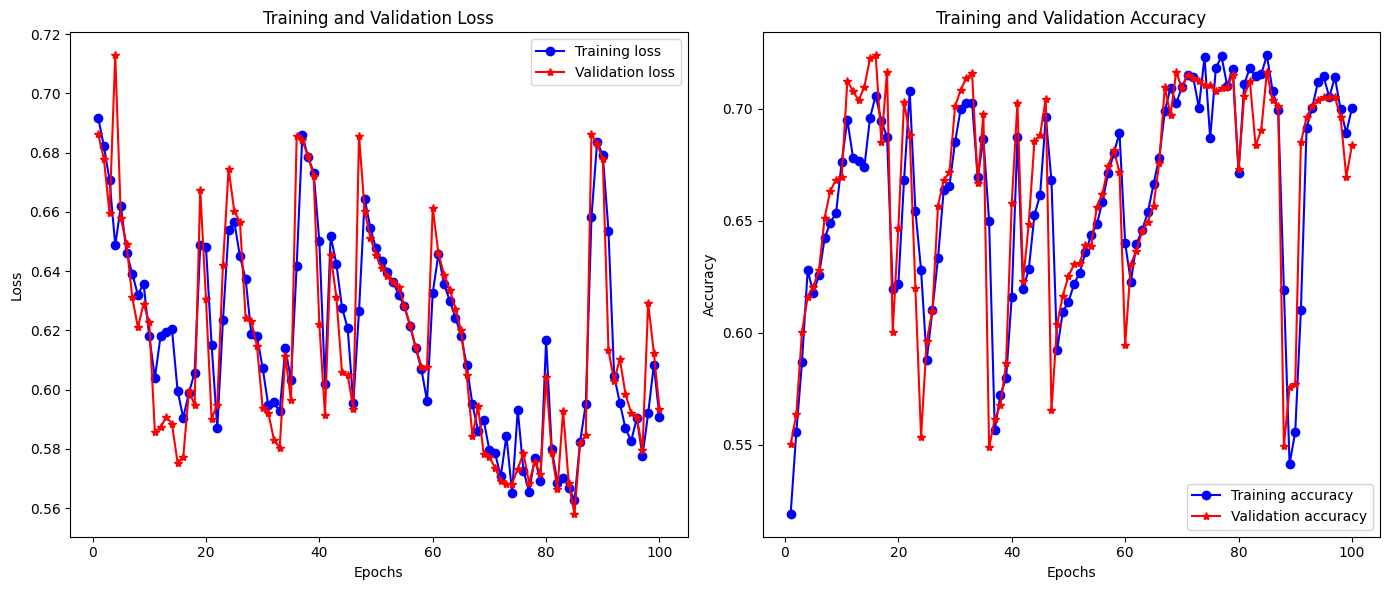

In [16]:
plotaccloss(history)

## LSTM

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1024, 1)))
model.add(LSTM(50))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2024-06-05 10:41:39.217271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 10:41:39.217356: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 10:41:39.217372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 10:41:39.359187: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 10:41:39.359292: I external/local_xla/xla/stream_executor

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1024, 50)       │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,702 (119.93 KB)

 Trainable params: 30,702 (119.93 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(x_train1, y_train1_encoded, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)

loss, accuracy = model.evaluate(x_test1, y_test1_encoded,verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/200


2024-06-05 10:41:41.077368: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.5224 - loss: 0.6939 - val_accuracy: 0.5382 - val_loss: 0.6907
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.5421 - loss: 0.6875 - val_accuracy: 0.5428 - val_loss: 0.6891
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.5542 - loss: 0.6847 - val_accuracy: 0.5450 - val_loss: 0.6861
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.5442 - loss: 0.6851 - val_accuracy: 0.5462 - val_loss: 0.6868
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.5485 - loss: 0.6848 - val_accuracy: 0.5536 - val_loss: 0.6858
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.5434 - loss: 0.6861 - val_accuracy: 0.5257 - val_loss: 0.6921
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.5454 - loss: 0.6859 - val_accuracy: 0.5445 - val_loss: 0.6872
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.5568 - loss: 0.6816 - val_accuracy: 0.5439 - va

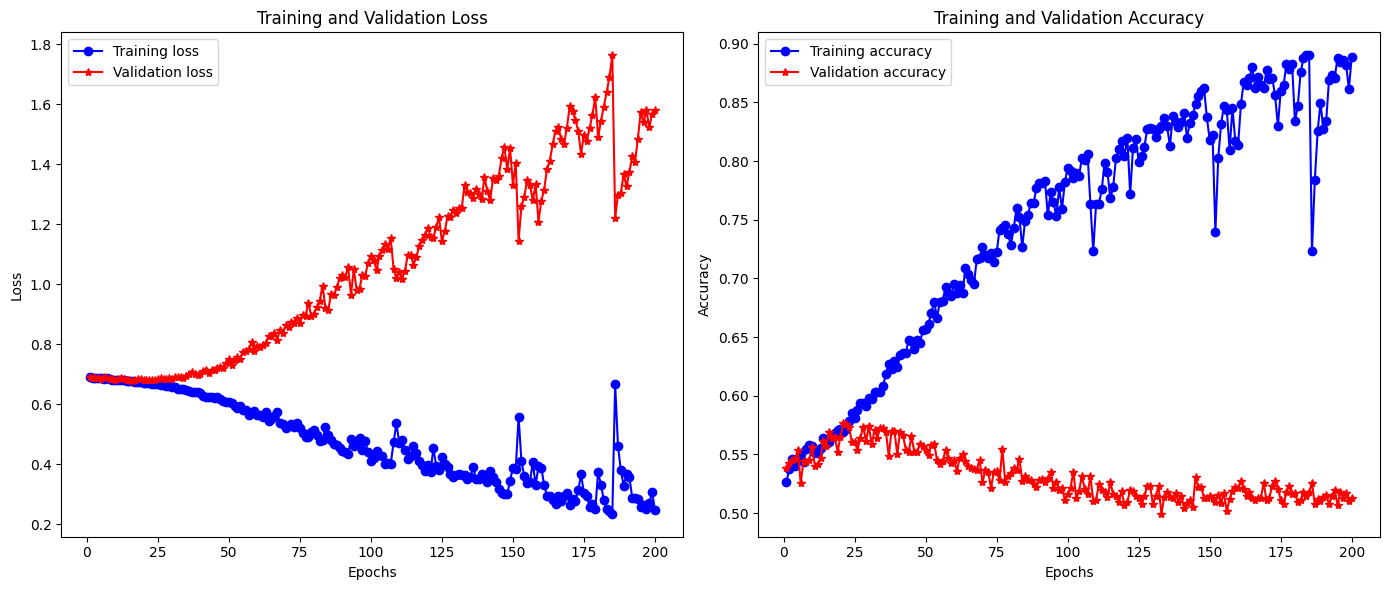

In [12]:
plotaccloss(history)


### L2, dropout

In [28]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1024, 1), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(50, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train1, y_train1_encoded, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)

loss, accuracy = model.evaluate(x_test1, y_test1_encoded,verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 1024, 50)       │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,702 (119.93 KB)

 Trainable params: 30,702 (119.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.5253 - loss: 1.3041 - val_accuracy: 0.5519 - val_loss: 0.8463
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.5280 - loss: 0.8048 - val_accuracy: 0.5502 - val_loss: 0.7253
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.5494 - loss: 0.7177 - val_accuracy: 0.5519 - val_loss: 0.7024
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.5316 - loss: 0.7007 - val_accuracy: 0.4869 - val_loss: 0.7138
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.5026 - loss: 0.7037 - val_accuracy: 0.4875 - val_loss: 0.6994
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.5020 - loss: 0.6976 - val_accuracy: 0.5068 - val_loss: 0.6981
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.5128 - loss: 0.6973 - val_accuracy: 0.5114 - val_loss: 0.6951
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.5188 - loss: 0.6942 - val_accuracy: 0.

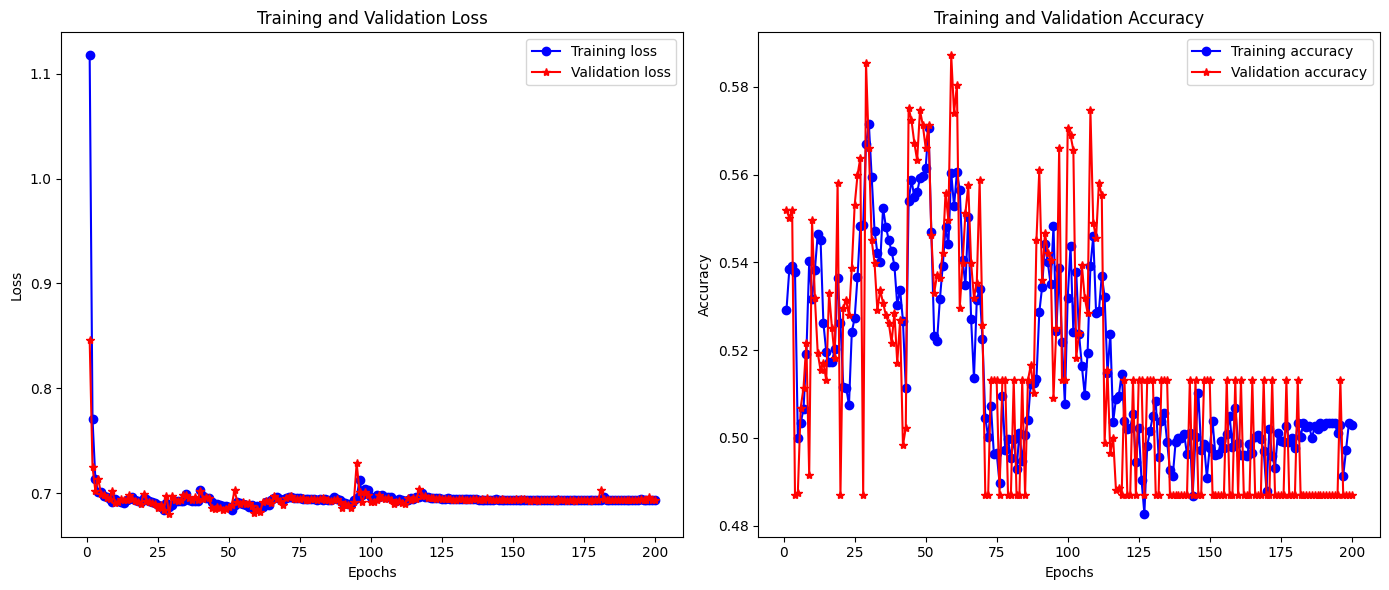

In [29]:
plotaccloss(history)

### L1, dropout

In [18]:
from keras.regularizers import l1

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1024, 1), kernel_regularizer=l1(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(50, kernel_regularizer=l1(0.01)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l1(0.01)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train1, y_train1_encoded, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)

loss, accuracy = model.evaluate(x_test1, y_test1_encoded,verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 1024, 50)       │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,702 (119.93 KB)

 Trainable params: 30,702 (119.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.5008 - loss: 6.7032 - val_accuracy: 0.5376 - val_loss: 2.0838
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.5245 - loss: 1.4440 - val_accuracy: 0.4869 - val_loss: 0.7509
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.5079 - loss: 0.7367 - val_accuracy: 0.4869 - val_loss: 0.7130
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.5021 - loss: 0.7097 - val_accuracy: 0.4869 - val_loss: 0.7049
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.5102 - loss: 0.7049 - val_accuracy: 0.4869 - val_loss: 0.7051
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5117 - loss: 0.7048 - val_accuracy: 0.4869 - val_loss: 0.7048
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5027 - loss: 0.7049 - val_accuracy: 0.4869 - val_loss: 0.7050
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.5010 - loss: 0.7049 - val_accuracy: 0.4869 

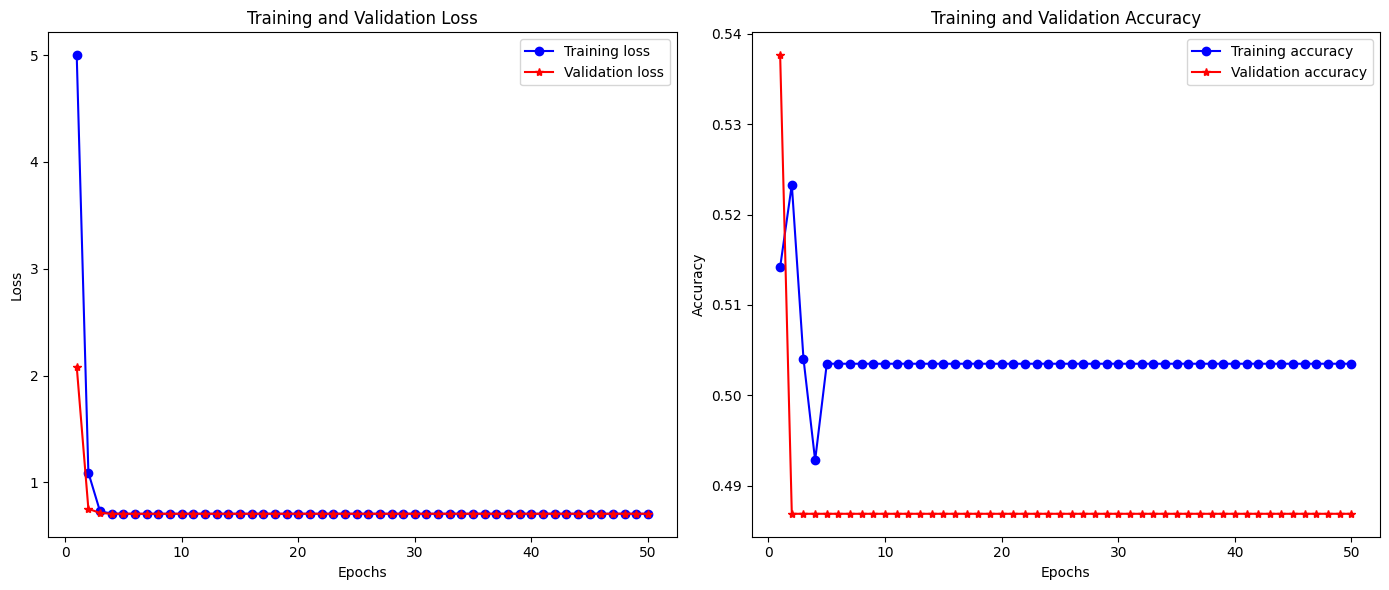

In [19]:
plotaccloss(history)

## LSTM - CNN

In [30]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(1024, 1)))
model.add(MaxPooling1D(2))
model.add(LSTM(50))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1022, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 511, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,358 (91.24 KB)

 Trainable params: 23,358 (91.24 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(x_train1, y_train1_encoded, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5216 - loss: 0.6960 - val_accuracy: 0.5570 - val_loss: 0.6868
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5416 - loss: 0.6881 - val_accuracy: 0.5439 - val_loss: 0.6905
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5566 - loss: 0.6839 - val_accuracy: 0.5388 - val_loss: 0.6882
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5532 - loss: 0.6859 - val_accuracy: 0.5559 - val_loss: 0.6854
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5427 - loss: 0.6877 - val_accuracy: 0.5439 - val_loss: 0.6862
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5577 - loss: 0.6828 - val_accuracy: 0.5758 - val_loss: 0.6824
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5576 - loss: 0.6863 - val_accuracy: 0.5804 - val_loss: 0.6814
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5521 - loss: 0.6841 - val_accuracy: 0.

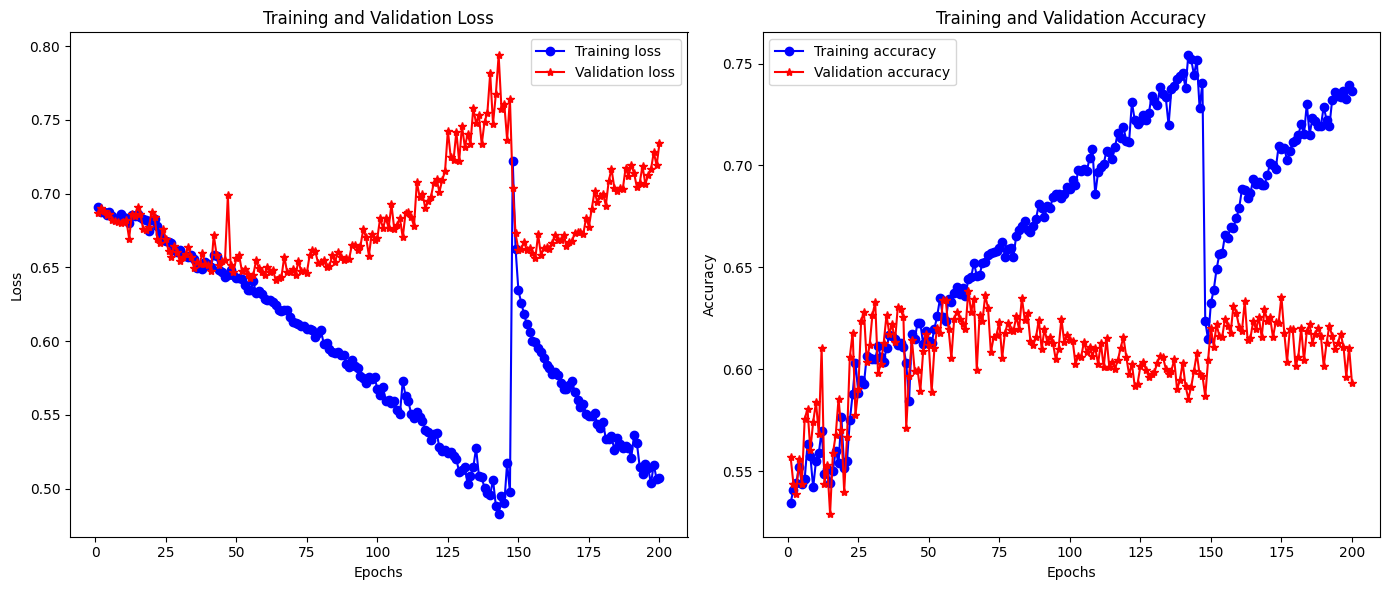

In [32]:
plotaccloss(history)


### L2, dropout

In [33]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.regularizers import l2

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(1024, 1), kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))
model.add(LSTM(50, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train1, y_train1_encoded, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)

loss, accuracy = model.evaluate(x_test1, y_test1_encoded,verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 1022, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 511, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 511, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,358 (91.24 KB)

 Trainable params: 23,358 (91.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.4965 - loss: 1.4732 - val_accuracy: 0.5473 - val_loss: 0.9475
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5425 - loss: 0.8923 - val_accuracy: 0.5433 - val_loss: 0.7813
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5368 - loss: 0.7713 - val_accuracy: 0.5433 - val_loss: 0.7360
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5437 - loss: 0.7299 - val_accuracy: 0.5285 - val_loss: 0.7190
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5183 - loss: 0.7160 - val_accuracy: 0.5490 - val_loss: 0.7054
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5388 - loss: 0.7049 - val_accuracy: 0.5388 - val_loss: 0.6989
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5378 - loss: 0.6990 - val_accuracy: 0.5399 - val_loss: 0.6948
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5428 - loss: 0.6945 - val_accuracy: 0.

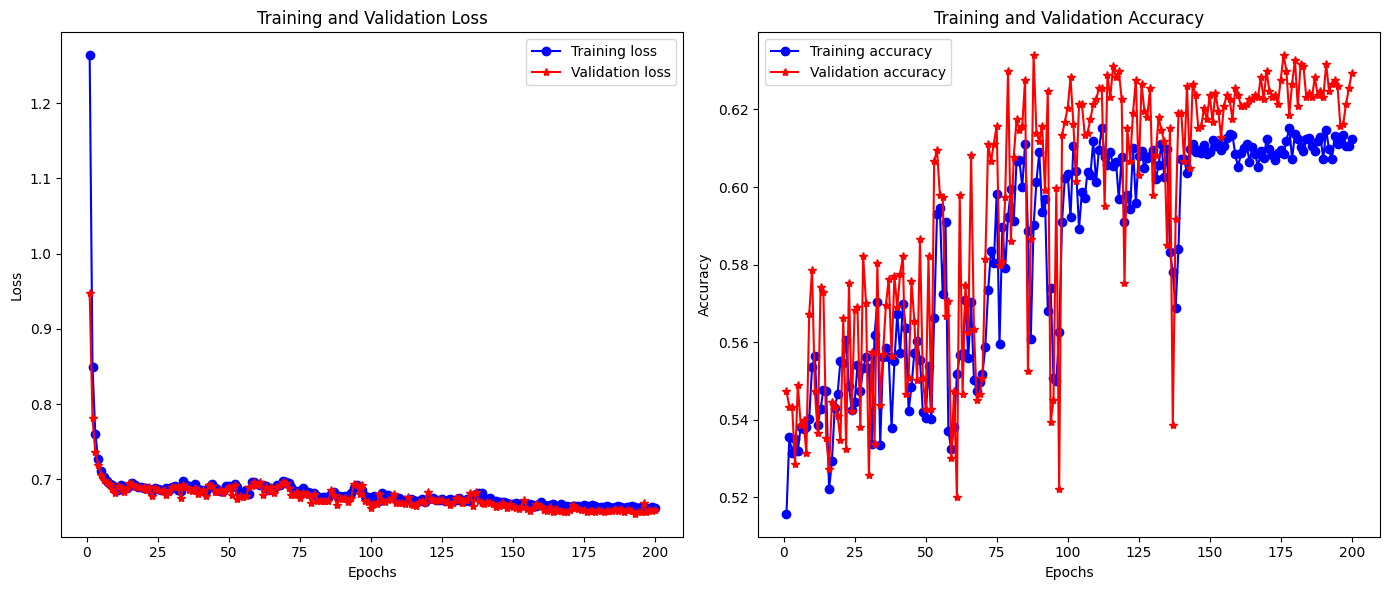

In [34]:
plotaccloss(history)

### L1, dropout

In [25]:
from keras.regularizers import l1

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(1024, 1), kernel_regularizer=l1(0.01)))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))
model.add(LSTM(50, kernel_regularizer=l1(0.01)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l1(0.01)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


history = model.fit(x_train1, y_train1_encoded, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)

loss, accuracy = model.evaluate(x_test1, y_test1_encoded,verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 1022, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 511, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 511, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,358 (91.24 KB)

 Trainable params: 23,358 (91.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5075 - loss: 8.2372 - val_accuracy: 0.5604 - val_loss: 2.5535
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5263 - loss: 1.7607 - val_accuracy: 0.5302 - val_loss: 0.8365
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5402 - loss: 0.8055 - val_accuracy: 0.5131 - val_loss: 0.7380
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4997 - loss: 0.7285 - val_accuracy: 0.5131 - val_loss: 0.7101
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5046 - loss: 0.7089 - val_accuracy: 0.5131 - val_loss: 0.7073
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4933 - loss: 0.7073 - val_accuracy: 0.4869 - val_loss: 0.7072
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5110 - loss: 0.7072 - val_accuracy: 0.4869 - val_loss: 0.7073
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5140 - loss: 0.7073 - val_accuracy: 0.4869 - v

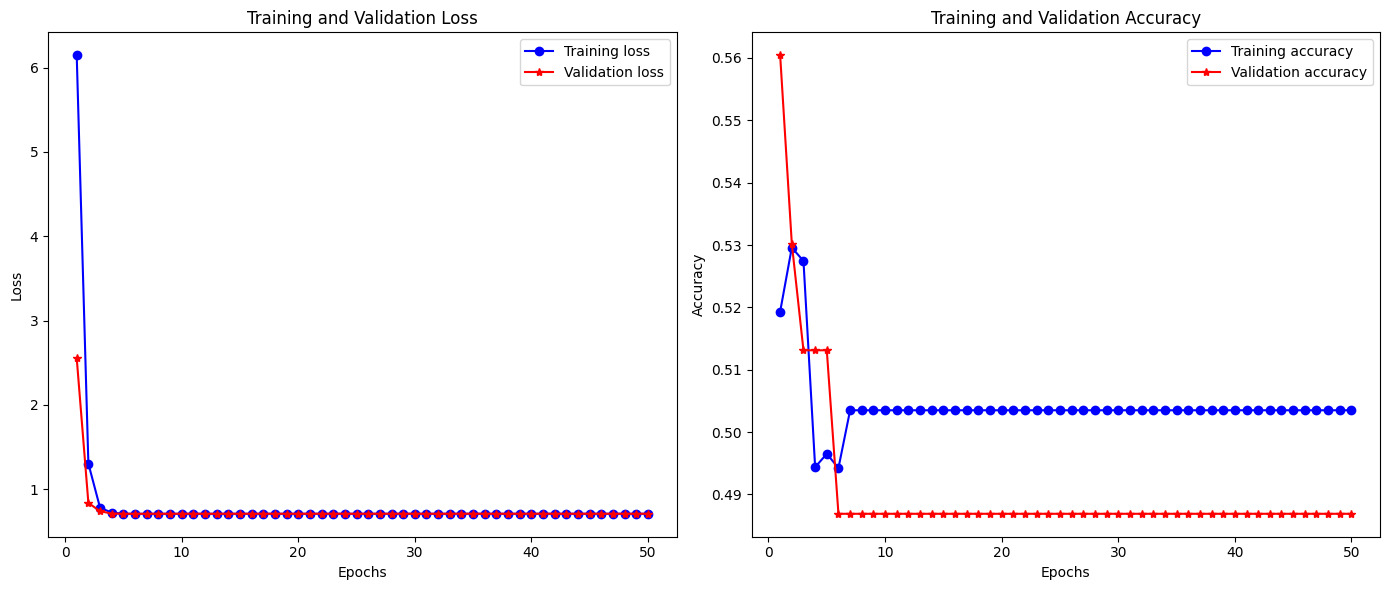

In [26]:
plotaccloss(history)

## LSTM3

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_43 (Conv1D)              │ (None, 1022, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 1020, 8)        │           776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 63, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 61, 16)         │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 61, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 59, 8)          │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 14, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 16)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,602 (14.07 KB)

 Trainable params: 3,602 (14.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5259 - loss: 0.6970 - val_accuracy: 0.5633 - val_loss: 0.6809
Epoch 2/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5843 - loss: 0.6750 - val_accuracy: 0.5410 - val_loss: 0.6918
Epoch 3/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6088 - loss: 0.6589 - val_accuracy: 0.5753 - val_loss: 0.6742
Epoch 4/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6060 - loss: 0.6599 - val_accuracy: 0.5422 - val_loss: 0.7039
Epoch 5/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6183 - loss: 0.6526 - val_accuracy: 0.5718 - val_loss: 0.6801
Epoch 6/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6163 - loss: 0.6532 - val_accuracy: 0.5935 - val_loss: 0.6623
Epoch 7/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6197 - loss: 0.6499 - val_accuracy: 0.5650 - val_loss: 0.6924
Epoch 8/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6147 - loss: 0.6473 - val_accuracy: 0.

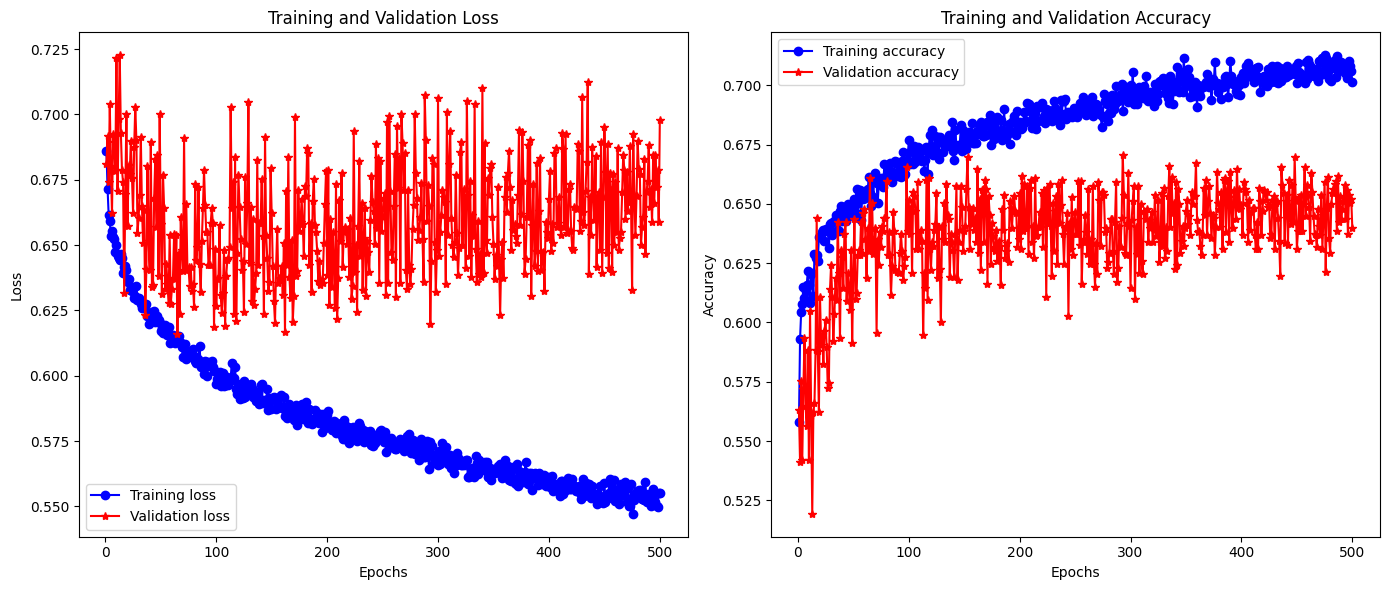

In [48]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, LSTM

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(1024, 1)))
model.add(Conv1D(8, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=16))
model.add(Conv1D(16, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(8, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(16, activation='relu'))
model.add(Dense(units=num_classes, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train1, y_train1_encoded, epochs=500, batch_size=batch_size, validation_split=0.2)

loss, accuracy = model.evaluate(x_test1, y_test1_encoded,verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

plotaccloss(history)

/home/pece/patrones/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 1024, 16)       │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 1022, 32)       │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 63, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_48 (Conv1D)              │ (None, 61, 8)          │           776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 61, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 59, 8)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 14, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,538 (21.63 KB)

 Trainable params: 5,538 (21.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5126 - loss: 0.6974 - val_accuracy: 0.5958 - val_loss: 0.6867
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5881 - loss: 0.6751 - val_accuracy: 0.6180 - val_loss: 0.6662
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6041 - loss: 0.6604 - val_accuracy: 0.6043 - val_loss: 0.6630
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6101 - loss: 0.6558 - val_accuracy: 0.6237 - val_loss: 0.6556
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6098 - loss: 0.6554 - val_accuracy: 0.6237 - val_loss: 0.6502
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6111 - loss: 0.6490 - val_accuracy: 0.6277 - val_loss: 0.6542
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6156 - loss: 0.6493 - val_accuracy: 0.6300 - val_loss: 0.6459
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6128 - loss: 0.6485 - val_accuracy: 0.

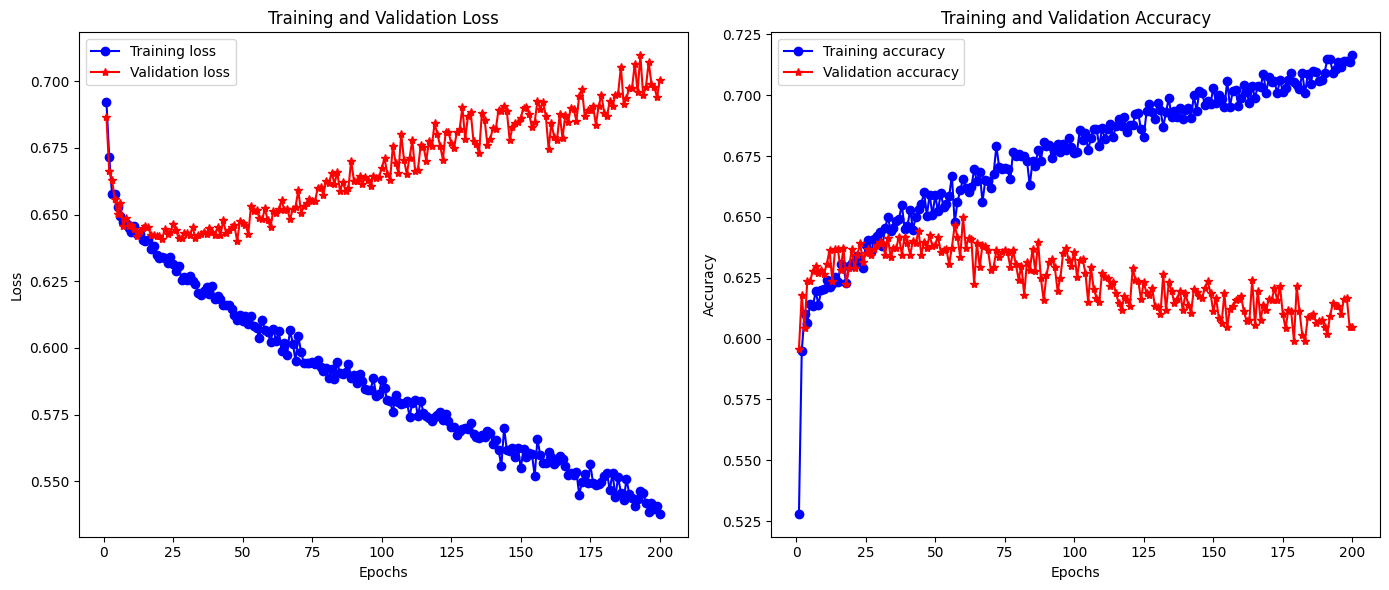

In [49]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, LSTM

model = Sequential()
model.add(LSTM(16, input_shape=(1024, 1), return_sequences=True))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=16))
model.add(Conv1D(8, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(8, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(units=num_classes, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train1, y_train1_encoded, epochs=200, batch_size=batch_size, validation_split=0.2)

loss, accuracy = model.evaluate(x_test1, y_test1_encoded,verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

plotaccloss(history)

## Kfolds

In [55]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from sklearn.model_selection import KFold
import numpy as np

param = 16
n_epochs = 10  # Define the number of epochs
kfold = KFold(n_splits=5, shuffle=True, random_state=1) 
fold_no = 1
acc_per_fold1 = []
loss_per_fold1 = []

for train, test in kfold.split(x_train1, y_train1):
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(1024, 1)))
    model.add(LSTM(16, return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(param, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history1 = model.fit(x_train1[train], y_train1[train],
                         batch_size=75,
                         epochs=n_epochs)

    # Generate generalization metrics
    scores1 = model.evaluate(x_train1[test], y_train1[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores1[0]}; {model.metrics_names[1]} of {scores1[1] * 100}%')
    acc_per_fold1.append(scores1[1] * 100)
    loss_per_fold1.append(scores1[0])

    # Increase fold number
    fold_no = fold_no + 1


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10


/home/pece/patrones/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.4937 - loss: 0.7006
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5319 - loss: 0.6897
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.5225 - loss: 0.6918
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.5335 - loss: 0.6894
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5384 - loss: 0.6876
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.5410 - loss: 0.6882
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5361 - loss: 0.6872
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5536 - loss: 0.6867
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.5503 - loss: 0.6862
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5526 - loss: 0.6840
Score for fold 1: loss of 0.687762975692749; compile_metrics of 53.078675270080566%
------------------------------------------------------------------------
Tra

In [56]:
# Print final results
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold1)):
  print(f'> Fold {i+1} - Loss: {loss_per_fold1[i]} - Accuracy: {acc_per_fold1[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold1)} (+- {np.std(acc_per_fold1)})')
print(f'> Loss: {np.mean(loss_per_fold1)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 0.687762975692749 - Accuracy: 53.078675270080566%
> Fold 2 - Loss: 0.6853293776512146 - Accuracy: 53.47776412963867%
> Fold 3 - Loss: 0.685509204864502 - Accuracy: 54.332953691482544%
> Fold 4 - Loss: 0.6865408420562744 - Accuracy: 55.53021430969238%
> Fold 5 - Loss: 0.6879879236221313 - Accuracy: 52.99486517906189%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 53.88289451599121 (+- 0.9503379496631694)
> Loss: 0.6866260647773743
------------------------------------------------------------------------
